# Learning the antiderivative operator from an aligned dataset

We will learn the antiderivative operator 

TODO: get markdown math expressions or latex working. Expressions not complete.

```
$$
G: v \mapsto u
$$
```

### References
[1] [Antiderivative operator from an aligned dataset - DeepXDE](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html)

[2] [DeepONet Tutorial in JAX](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb)

## Current issues / TODOs
* Need to figure out how hard it would be to transpose the data back to the intended shape
* Need to implement a predict method
* Need to define a class for re-use
* Need train/dev/test split for expected Problem setup, should we be using Problem? Or should I manually set up a training loop
* Test batch size
* How can I use "Glorot normal" aka xavier uniform initialization for the MLPs
    * [torch.nn.init.xavier_uniform_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_)
* Am i using the correct loss metric? currently MSE but deepxde uses "mean l2 relative error"
* Is early stopping currently working?
* Should I be using a callback for keeping track of loss?

### Import

In [1]:
# https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import sys
sys.path.append('neuromancer_deeponet/src')

In [2]:
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.problem import Problem
from neuromancer.system import Node, System
from neuromancer.trainer import Trainer

## Dataset

In [3]:
#data_dir = "datasets/deeponet_antiderivative_aligned"
data_dir = "examples/DeepONets/datasets"

### Prepare Train data

In [4]:
# load original dataset numpy arrays
dataset_train = np.load(f"{data_dir}/antiderivative_aligned_train.npz", allow_pickle=True)

 ## Note: transposing branch input because DictDataset in Neuromancer needs all tensors in the dict to have the same shape at index 0
branch_inputs_train = dataset_train["X"][0].T
trunk_inputs_train = dataset_train["X"][1]
outputs_train = dataset_train["y"].T

print(branch_inputs_train.shape)
print(trunk_inputs_train.shape)
print(outputs_train.shape)

## Global definition of Nu and Nsamples:
## This example has 100 points (resolution of x and u(x))
## and 150 samples of functions
Nu = outputs_train.shape[0]
Nsamples = outputs_train.shape[1]
print(f'Nu = {Nu}')
print(f'Nsamples = {Nsamples}')

# convert to pytorch tensors of float type
t_branch_inputs_train = torch.from_numpy(branch_inputs_train).float()
t_trunk_inputs_train = torch.from_numpy(trunk_inputs_train).float()
t_outputs_train = torch.from_numpy(outputs_train).float()

print(t_branch_inputs_train.shape)
print(t_trunk_inputs_train.shape)
print(t_outputs_train.shape)


# create named dictionary dataset
samples_train = {
    "branch_inputs": t_branch_inputs_train,
    "trunk_inputs": t_trunk_inputs_train,
    "outputs": t_outputs_train
}

(100, 150)
(100, 1)
(100, 150)
Nu = 100
Nsamples = 150
torch.Size([100, 150])
torch.Size([100, 1])
torch.Size([100, 150])


### Prepare Test Data

In [5]:
dataset_test = np.load(f"{data_dir}/antiderivative_aligned_test.npz", allow_pickle=True)
branch_inputs_test = dataset_test["X"][0].T
trunk_inputs_test = dataset_test["X"][1]
outputs_test = dataset_test["y"].T

print(branch_inputs_test.shape)
print(trunk_inputs_test.shape)
print(outputs_test.shape)

t_branch_inputs_test = torch.from_numpy(branch_inputs_test).float()
t_reshaped_trunk_inputs_test = torch.from_numpy(trunk_inputs_test).float()
t_outputs_test = torch.from_numpy(outputs_test).float()

samples_test = {
    "branch_inputs": t_branch_inputs_test,
    "trunk_inputs": t_reshaped_trunk_inputs_test,
    "outputs": t_outputs_test
}

(100, 1000)
(100, 1)
(100, 1000)


### Create named dictionary datasets

In [6]:
train_data = DictDataset(samples_train, name="train")
#dev_data = DictDataset(samples_dev, name="dev")
test_data = DictDataset(samples_test, name="test")

### Create torch DataLoaders for the Trainer

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=150, collate_fn=train_data.collate_fn, shuffle=False)
#dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=150, collate_fn=dev_data.collate_fn, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=150, collate_fn=test_data.collate_fn, shuffle=False)

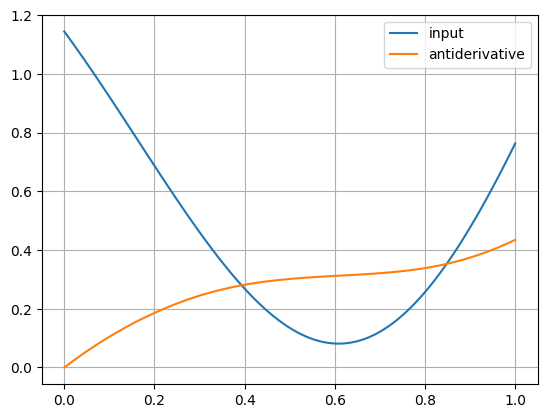

In [8]:
# Due to the dataset being aligned, we can use the trunk inputs as a grid
k = 2
plt.plot(
    train_data.datadict['trunk_inputs'],
    train_data.datadict['branch_inputs'][:,k],
    label="input",
)
plt.plot(
    train_data.datadict['trunk_inputs'],
    train_data.datadict['outputs'][:,k],
    label="antiderivative",
)
plt.legend()
plt.grid()

## Define nodes

In [9]:
train_data.datadict.keys()

dict_keys(['branch_inputs', 'trunk_inputs', 'outputs'])

In [10]:
train_data.datadict["branch_inputs"].shape

torch.Size([100, 150])

In [11]:
# Can I create a system composed of MLPS? Do I even need system or can I just wrap with nodes?
# inputs from jax example

in_size_branch = Nu
width_size = 40
depth_branch = 2
interact_size = 40
#activation = torch.nn.ReLU
linear_map = torch.nn.Linear
# key?
# should bias be true? Looks like Yes, https://docs.kidger.site/equinox/api/nn/mlp/
block_branch = blocks.MLP(
    insize=in_size_branch,
    outsize=interact_size,
    bias=True,
    nonlin=activations['relu'],
    hsizes=[width_size] * depth_branch
)
branch_net = Node(block_branch, ['reshaped_branch_inputs'], ['branch_outputs'], name="branch_net")
print(branch_net.input_keys)
print(branch_net.output_keys)
print(branch_net({"reshaped_branch_inputs": t_branch_inputs_train.T}))
print(branch_net({"reshaped_branch_inputs": t_branch_inputs_train.T})['branch_outputs'].shape)


['reshaped_branch_inputs']
['branch_outputs']
{'branch_outputs': tensor([[-0.0522, -0.0335,  0.0405,  ...,  0.1795, -0.2215,  0.0545],
        [-0.0381,  0.0274, -0.0607,  ...,  0.1087, -0.0291,  0.0978],
        [-0.0300,  0.0053, -0.0384,  ...,  0.0943, -0.0146,  0.1272],
        ...,
        [-0.0140,  0.0263, -0.0043,  ...,  0.1666, -0.1450,  0.0722],
        [ 0.0376,  0.0011,  0.0830,  ...,  0.2645, -0.1044,  0.1118],
        [-0.0434, -0.0416, -0.0217,  ...,  0.0123, -0.0856,  0.0471]],
       grad_fn=<AddmmBackward0>)}
torch.Size([150, 40])


In [12]:
## Transpose for branch net
lam_transpose = lambda x_in: torch.transpose(x_in, 0, 1)
node_transpose_branch = Node(lam_transpose, ['branch_inputs'], ["reshaped_branch_inputs"], name="transpose")


In [13]:
in_size_trunk = 1
depth_trunk = 2
block_trunk = blocks.MLP(
    insize=in_size_trunk,
    outsize=interact_size,
    bias=True,
    nonlin=activations['relu'],
    hsizes= [width_size]*depth_trunk
)
trunk_net = Node(block_trunk, ["trunk_inputs"], ["trunk_outputs"], name="trunk_net")
print(trunk_net.input_keys)
print(trunk_net.output_keys)

print(trunk_net({'trunk_inputs':train_data.datadict['trunk_inputs']})["trunk_outputs"])
print(trunk_net({'trunk_inputs':train_data.datadict['trunk_inputs']})["trunk_outputs"].shape)


['trunk_inputs']
['trunk_outputs']
tensor([[-0.0300,  0.0687,  0.0089,  ..., -0.0952, -0.1958, -0.0153],
        [-0.0306,  0.0681,  0.0080,  ..., -0.0953, -0.1954, -0.0157],
        [-0.0313,  0.0676,  0.0071,  ..., -0.0953, -0.1949, -0.0162],
        ...,
        [-0.0995,  0.0972, -0.1083,  ..., -0.1314, -0.1775, -0.1535],
        [-0.1000,  0.0974, -0.1099,  ..., -0.1310, -0.1772, -0.1550],
        [-0.1005,  0.0975, -0.1115,  ..., -0.1306, -0.1770, -0.1566]],
       grad_fn=<AddmmBackward0>)
torch.Size([100, 40])


In [14]:
## Todo: add a bias term here
bias = torch.rand(1,)#* 1000
bias.requires_grad_(True)
lam_multiply = lambda branch_output, trunk_output: torch.matmul(branch_output, trunk_output.T) + bias
node_multiply = Node(lam_multiply, ['branch_outputs', 'trunk_outputs'], ['g'], name="multiply_and_bias")

In [15]:
print(branch_net)
print(node_transpose_branch)
print(trunk_net)
print(node_multiply)

branch_net(reshaped_branch_inputs) -> branch_outputs
transpose(branch_inputs) -> reshaped_branch_inputs
trunk_net(trunk_inputs) -> trunk_outputs
multiply_and_bias(branch_outputs, trunk_outputs) -> g


In [16]:
## Testing all the nets to see if they are returning the expected shapes
res_transpose = node_transpose_branch({'branch_inputs':train_data.datadict['branch_inputs']})["reshaped_branch_inputs"]
res_branch = branch_net({'reshaped_branch_inputs':res_transpose})["branch_outputs"]
res_trunk = trunk_net({'trunk_inputs':train_data.datadict['trunk_inputs']})["trunk_outputs"]
res_multiply = node_multiply({'branch_outputs':res_branch, 'trunk_outputs':res_trunk})['g']
print(res_transpose.shape)
print(res_branch.shape)
print(res_trunk.shape)
print(res_multiply.shape)


torch.Size([150, 100])
torch.Size([150, 40])
torch.Size([100, 40])
torch.Size([150, 100])


## Objective and Constraints in NeuroMANCER

In [17]:
var_y_est = variable("g")
var_y_true = variable("outputs")

nodes = [node_transpose_branch, branch_net, trunk_net, node_multiply]

var_loss = (var_y_est == var_y_true.T)^2

# need to implement "mean l2 relative error" from deepxde
#var_loss = (((var_y_est - var_y_true.T) / var_y_true.T + 0.000000000001) == 0.0)^2
# https://pytorch.org/docs/stable/generated/torch.linalg.norm.html
#var_loss = torch.linalg.norm(var_y_true - var_y_est, axis=1) / torch.linalg.norm(var_y_true, axis=1)
#var_loss = (var_y_est == var_y_true) / var_y_true
var_loss.name = "residual_loss"
objectives = [var_loss]

loss = PenaltyLoss(objectives, constraints=[])

problem = Problem(nodes, loss=loss, grad_inference=True)


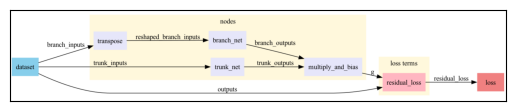

In [18]:
# brew install graphviz
problem.show()

## Problem Solution in NeuroMANCER

In [19]:
lr = 0.001      # step size for gradient descent
epochs = 10000  # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 0 #5    # number of epochs with no improvement in eval metric to allow before early stopping

In [20]:
optimizer = torch.optim.Adam(problem.parameters(), lr=lr) # double check Adam params

# define trainer
trainer = Trainer(
    problem,
    train_data=train_loader,
    #dev_data=test_loader,
    optimizer=optimizer,
    epochs=epochs,
    patience=patience,
    #epoch_verbose=100,
    train_metric='train_loss',
    #dev_metric='dev_loss',
    #eval_metric='dev_loss',
    eval_metric="train_loss",
    warmup = epochs
)

In [21]:
%%time
best_model = trainer.train()


epoch: 0  train_loss: 0.38062331080436707
epoch: 1  train_loss: 0.3044910430908203
epoch: 2  train_loss: 0.2407979816198349
epoch: 3  train_loss: 0.1866810917854309
epoch: 4  train_loss: 0.14252543449401855
epoch: 5  train_loss: 0.11044569313526154
epoch: 6  train_loss: 0.09286200255155563
epoch: 7  train_loss: 0.08972629904747009
epoch: 8  train_loss: 0.09162849187850952
epoch: 9  train_loss: 0.08853434026241302
epoch: 10  train_loss: 0.07982809096574783
epoch: 11  train_loss: 0.0700436607003212
epoch: 12  train_loss: 0.06271368265151978
epoch: 13  train_loss: 0.05872684717178345
epoch: 14  train_loss: 0.05702758952975273
epoch: 15  train_loss: 0.05598793178796768
epoch: 16  train_loss: 0.054311636835336685
epoch: 17  train_loss: 0.05157995596528053
epoch: 18  train_loss: 0.047899384051561356
epoch: 19  train_loss: 0.04370417818427086
epoch: 20  train_loss: 0.03949812799692154
epoch: 21  train_loss: 0.03574356809258461
epoch: 22  train_loss: 0.03268340229988098
epoch: 23  train_loss: 

In [22]:
train_loss_history = [l.detach().numpy() for l in trainer.loss_history["train"]]
dev_loss_history = [l.detach().numpy() for l in trainer.loss_history["dev"]]

## plot loss history

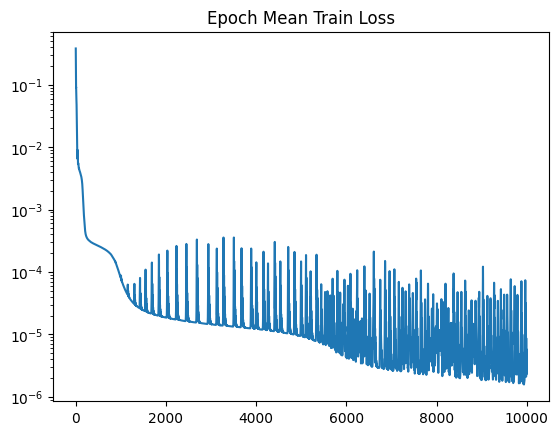

In [23]:
plt.semilogy(train_loss_history)
plt.title("Epoch Mean Train Loss")
plt.show()

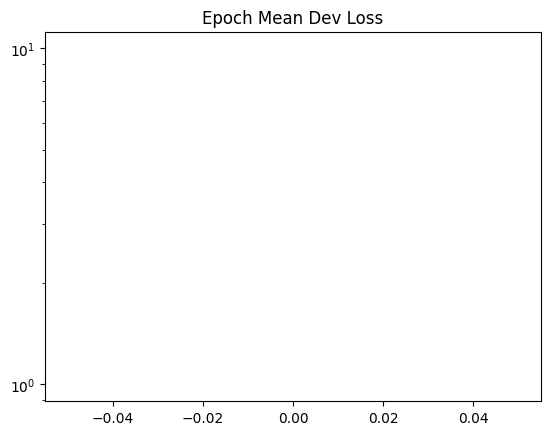

In [24]:
plt.semilogy(dev_loss_history)
plt.title("Epoch Mean Dev Loss")
plt.show()

## test trainer (need to add dev dataset)

In [25]:
#best_outputs = trainer.test(best_model)

In [26]:
# load best trained model
problem.load_state_dict(best_model)

<All keys matched successfully>

In [27]:
# (not working) Evaluate trained PINN on data (all the data in the domain)
#val_u = problem(train_data.datadict)


## Compare results

torch.Size([100, 1]) torch.Size([100, 1])


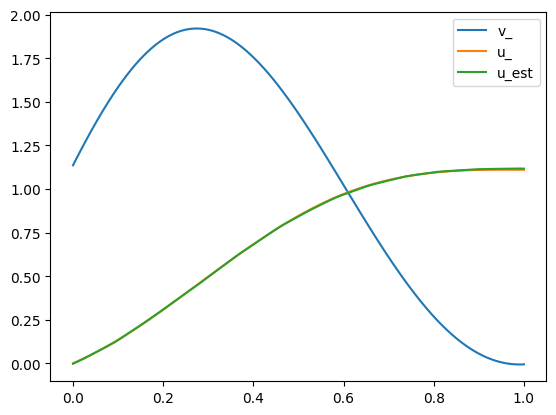

In [28]:
k = 0 # k is the k-th function among the 1000 test functions
v_ = test_data.datadict["branch_inputs"][:,k].reshape(-1,1)
x_ = test_data.datadict["trunk_inputs"]
#v_ = train_data.datadict["branch_inputs"][:,k].reshape(-1,1)
#x_ = train_data.datadict["trunk_inputs"]
print(v_.shape, x_.shape)


## Note: Neuromancer needs a better forward method to 'predict' after the model is trained
## This is a workaround that I found (forward pass with zero 'outputs')
## You could also use a problem.step({'branch_inputs':v_, 'trunk_inputs':x_}) here, but that is not as great
## as it computes the gradients again.
res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = test_data.datadict["outputs"][:,k]
#u_ = train_data.datadict["outputs"][:,k]
u_est = res['g'].T

plt.plot(x_.detach().numpy(), v_.detach().numpy(),label='v_')
plt.plot(x_.detach().numpy(), u_.detach().numpy(),label='u_')
plt.plot(x_.detach().numpy(), u_est.detach().numpy(),label='u_est')

plt.legend()


torch.Size([100, 1]) torch.Size([100, 1])


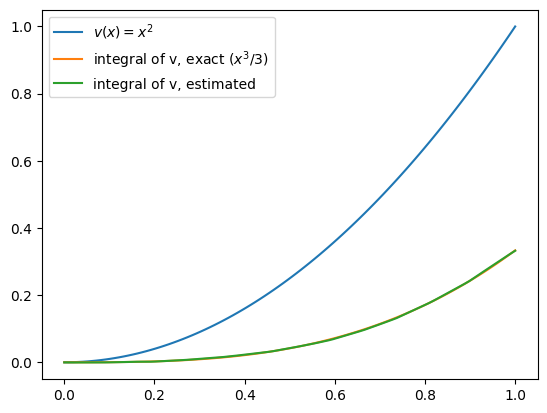

In [29]:
x_ = train_data.datadict["trunk_inputs"]
v_ = torch.pow(x_,2).reshape(-1,1)

print(v_.shape, x_.shape)
res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = (1./3.)*torch.pow(x_,3).reshape(-1,1)
u_est = res['g'].T

plt.plot(x_.detach().numpy(), v_.detach().numpy(),label='$v(x) = x^2$')
plt.plot(x_.detach().numpy(), u_.detach().numpy(),label='integral of v, exact ($x^3/3$)')
plt.plot(x_.detach().numpy(), u_est.detach().numpy(),label='integral of v, estimated')
plt.legend()


## Compare: NeuroMANCER vs. DeepXDE